In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
from cartopy import crs as ccrs
from sklearn.metrics import mean_absolute_error


Bad key "text.kerning_factor" on line 4 in
/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [27]:
# Define plot size
plt.rcParams["figure.figsize"] = (15,5)

In [3]:
# H2O AutoML framework for benchmarking
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size = 32)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 days 4 hours 0 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,2 months and 12 days
H2O_cluster_name:,H2O_from_python_moc0_j96c9b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16.30 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


This notebook uses the H2O.ai AutoML framework to model transformed outcome and predictors. It visualises averaged results over a map and uses the H2O.ai explainability module to identify model limitations and possible future avenues for improvements.

# Load data

In [4]:
# Define working directory
os.chdir('/home/moc0/ai-vegetation-fuel')

In [5]:
# Load train data
train = pd.read_csv(os.getcwd() + "/data/inputs/train_interpTrue_preprocessed.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})
train = train.drop('Unnamed: 0', axis = 1)
train_data = h2o.H2OFrame(train)

# Load test data
test = pd.read_csv(os.getcwd() + "/data/inputs/test_interpTrue_preprocessed.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})
test = test.drop('Unnamed: 0', axis = 1)
test_data = h2o.H2OFrame(test)

# Load raw test data
test_raw = pd.read_csv(os.getcwd() + "/data/inputs/test_interpTrue_raw.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})
test_raw = test_raw.drop('Unnamed: 0', axis = 1)

In [12]:
train_data = h2o.H2OFrame(train)
test_data = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
# Define outcome variable
y = 'log_dry_matter'

# Define Regressor model
aml = H2OAutoML(max_runtime_secs = 10*60*60, seed = 1, stopping_metric = "mae",
                preprocessing = ["target_encoding"])
# Fit
aml.train(y = y, training_frame = train_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [7]:
# MAE
pre = aml.predict(test_data)
pre = np.exp(pre.as_data_frame())
obs = test_raw['dry_matter']
mean_absolute_error(obs, pre)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


43.86178687465157

In [8]:
# View the AutoML Leaderboard - uses validation metrics
lb = aml.leaderboard
lb.head()
# lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210607_163002,1.26954,1.12674,1.26954,0.879706,nan
StackedEnsemble_BestOfFamily_AutoML_20210607_163002,1.30452,1.14216,1.30452,0.89436,nan
GBM_grid__1_AutoML_20210607_163002_model_56,1.327,1.15195,1.327,0.903173,nan
GBM_grid__1_AutoML_20210607_163002_model_44,1.36617,1.16883,1.36617,0.91748,nan
GBM_grid__1_AutoML_20210607_163002_model_25,1.3715,1.17111,1.3715,0.920402,nan
GBM_grid__1_AutoML_20210607_163002_model_34,1.37222,1.17142,1.37222,0.918598,nan
GBM_grid__1_AutoML_20210607_163002_model_16,1.37375,1.17207,1.37375,0.921342,nan
XGBoost_grid__1_AutoML_20210607_163002_model_51,1.38061,1.17499,1.38061,0.921333,nan
GBM_grid__1_AutoML_20210607_163002_model_78,1.38208,1.17562,1.38208,0.923067,nan
GBM_grid__1_AutoML_20210607_163002_model_99,1.38243,1.17577,1.38243,0.920229,nan


In [13]:
# Predict using test data and second model
aml2 = h2o.get_model(aml.leaderboard[1, "model_id"])
pre = np.exp(aml2.predict(test_data).as_data_frame())

# Get performance - transformed 
mean_absolute_error(obs, pre)

stackedensemble prediction progress: |████████████████████████████████████| 100%


45.310096410231814

In [14]:
# Predict using test data and third model
aml3 = h2o.get_model(aml.leaderboard[2, "model_id"])
pre = np.exp(aml3.predict(test_data).as_data_frame())

# Get performance - transformed 
mean_absolute_error(obs, pre)

gbm prediction progress: |████████████████████████████████████████████████| 100%


46.23623950571551

In [9]:
# Performance on test data
aml.leader.model_performance(test_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.2343500368031128
RMSE: 1.1110130677913346
MAE: 0.867289494712053
RMSLE: NaN
R^2: 0.7178156241812261
Mean Residual Deviance: 1.2343500368031128
Null degrees of freedom: 132508
Residual degrees of freedom: 132486
Null deviance: 579630.3950803857
Residual deviance: 163562.4890267437
AIC: 403991.29937958176


In [10]:
# The leader model is stored here
# aml.leader

# Save the leader model
leadermodel_path = h2o.save_model(aml.leader, path = "/home/moc0/ai-vegetation-fuel/data/outputs", force = True)
print(leadermodel_path)

# Load the model
# saved_model = h2o.load_model(model_path)

/home/moc0/ai-vegetation-fuel/data/outputs/StackedEnsemble_AllModels_AutoML_20210607_163002


# Visualise results

Explainability
See https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#explainability and https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

Parse progress: |█████████████████████████████████████████████████████████| 100%


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_AutoML_20210607_163002,1.26954,1.12674,1.26954,0.879706,nan,8851,0.045374,StackedEnsemble
StackedEnsemble_BestOfFamily_AutoML_20210607_163002,1.30452,1.14216,1.30452,0.89436,nan,765,0.004911,StackedEnsemble
GBM_grid__1_AutoML_20210607_163002_model_56,1.327,1.15195,1.327,0.903173,nan,25170,0.003743,GBM
GBM_grid__1_AutoML_20210607_163002_model_44,1.36617,1.16883,1.36617,0.91748,nan,17868,0.00544,GBM
GBM_grid__1_AutoML_20210607_163002_model_25,1.3715,1.17111,1.3715,0.920402,nan,18995,0.002782,GBM
GBM_grid__1_AutoML_20210607_163002_model_34,1.37222,1.17142,1.37222,0.918598,nan,22237,0.003631,GBM
GBM_grid__1_AutoML_20210607_163002_model_16,1.37375,1.17207,1.37375,0.921342,nan,14428,0.003112,GBM
XGBoost_grid__1_AutoML_20210607_163002_model_51,1.38061,1.17499,1.38061,0.921333,nan,28355,0.001478,XGBoost
GBM_grid__1_AutoML_20210607_163002_model_78,1.38208,1.17562,1.38208,0.923067,nan,16272,0.004717,GBM
GBM_grid__1_AutoML_20210607_163002_model_99,1.38243,1.17577,1.38243,0.920229,nan,39663,0.004755,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

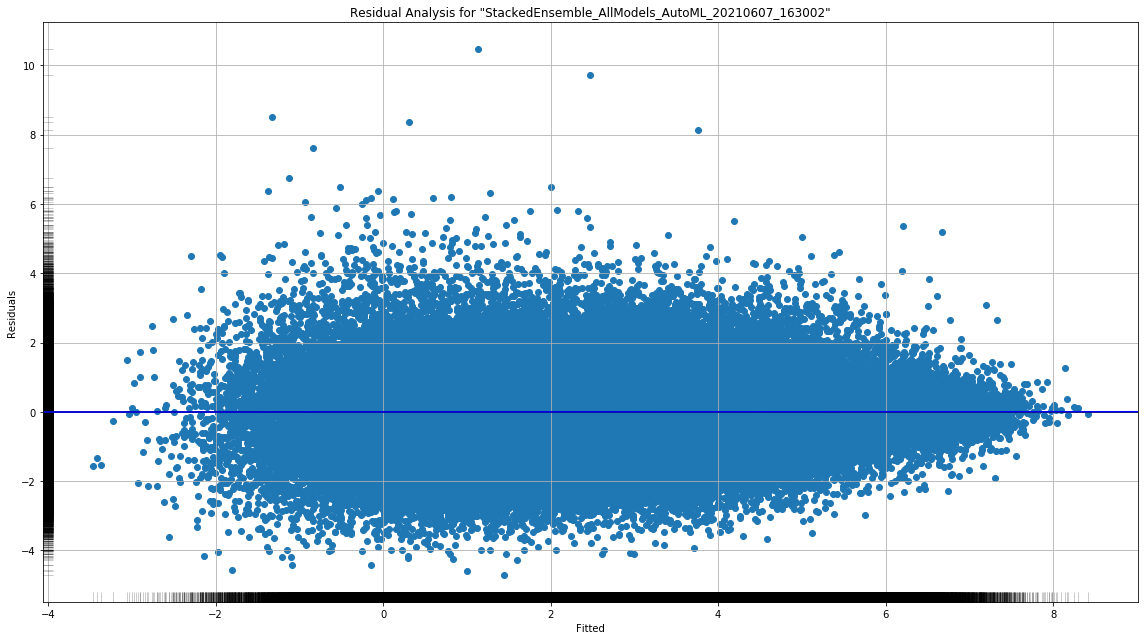

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

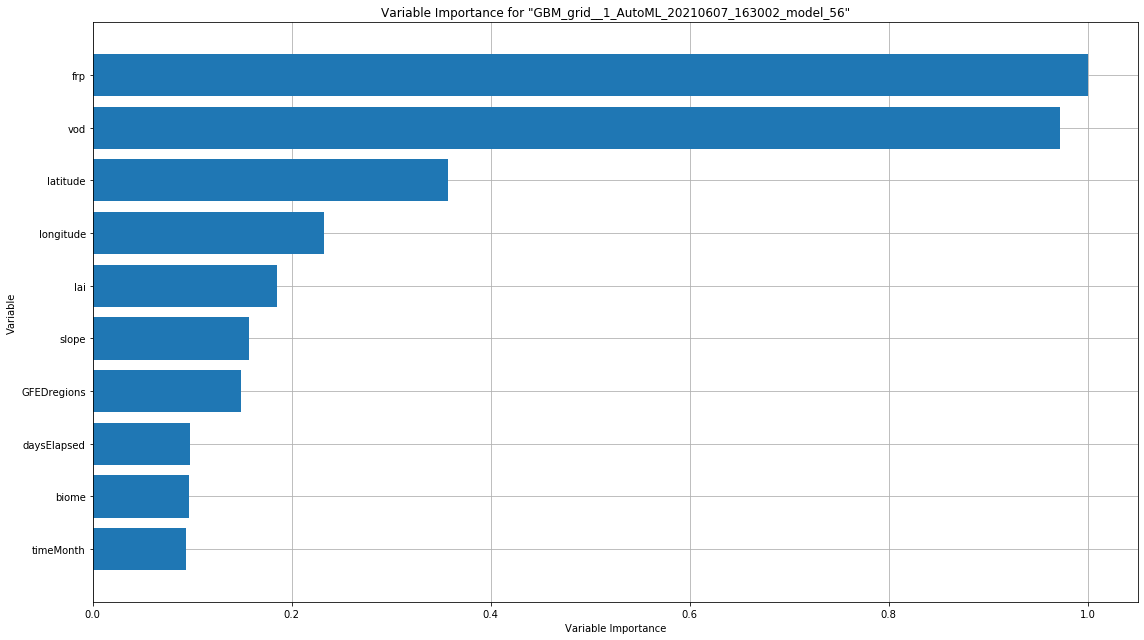

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

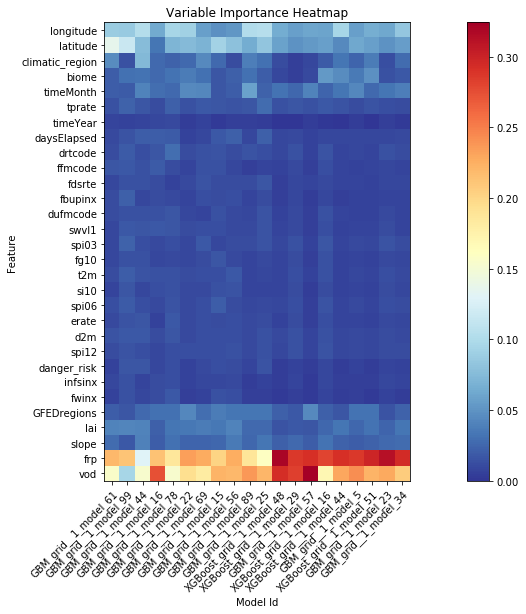

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

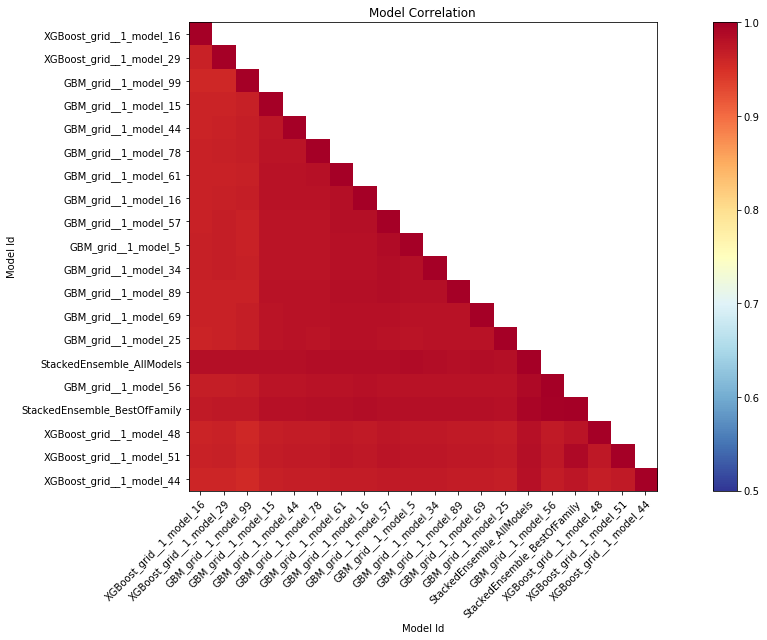

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

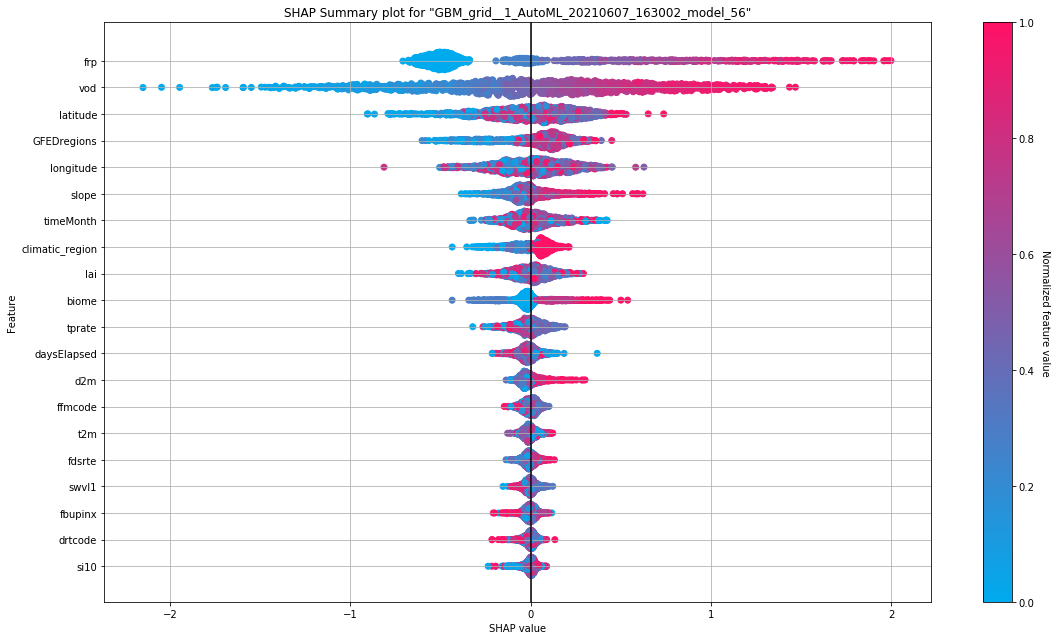

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

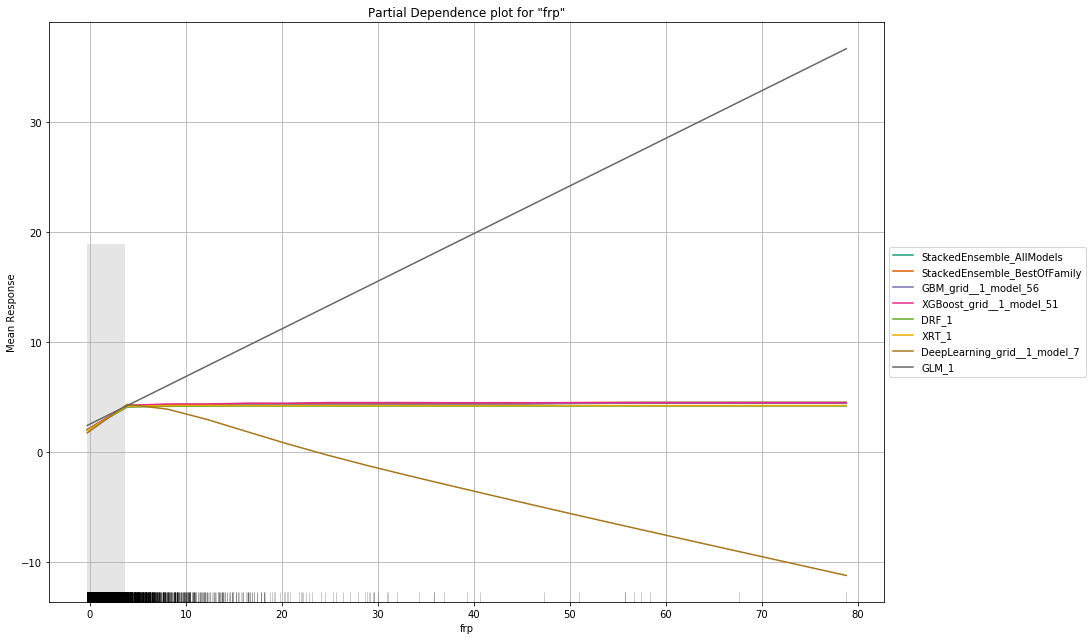

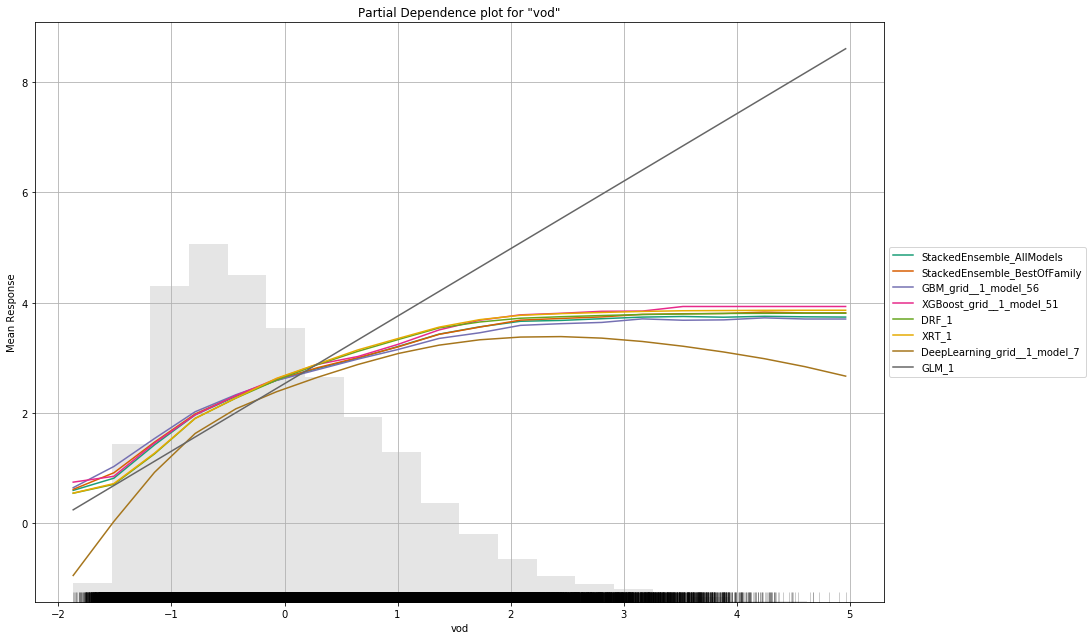

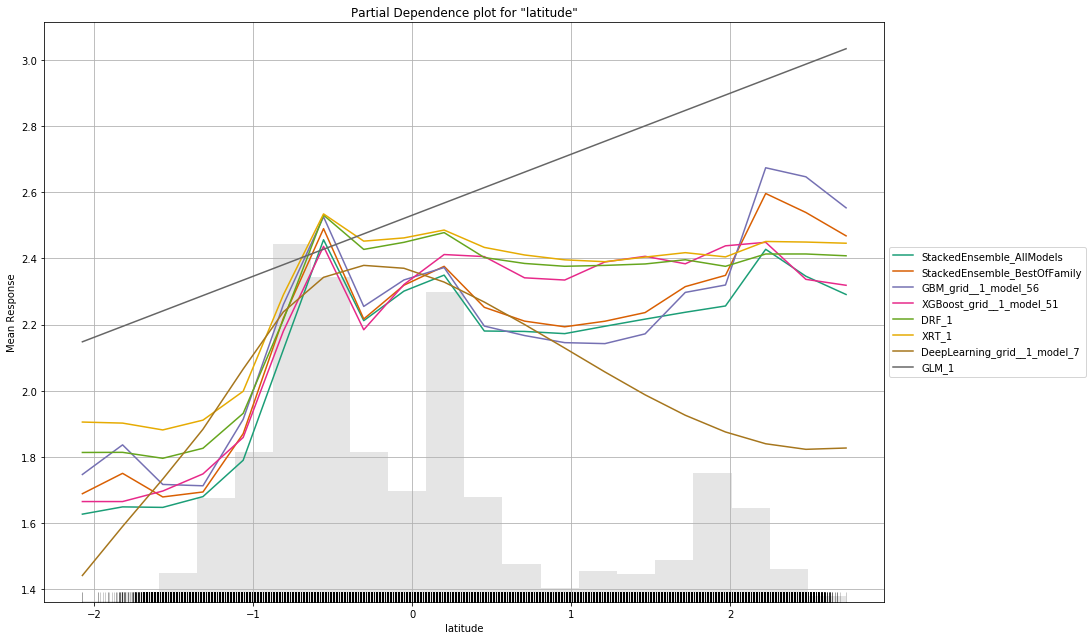

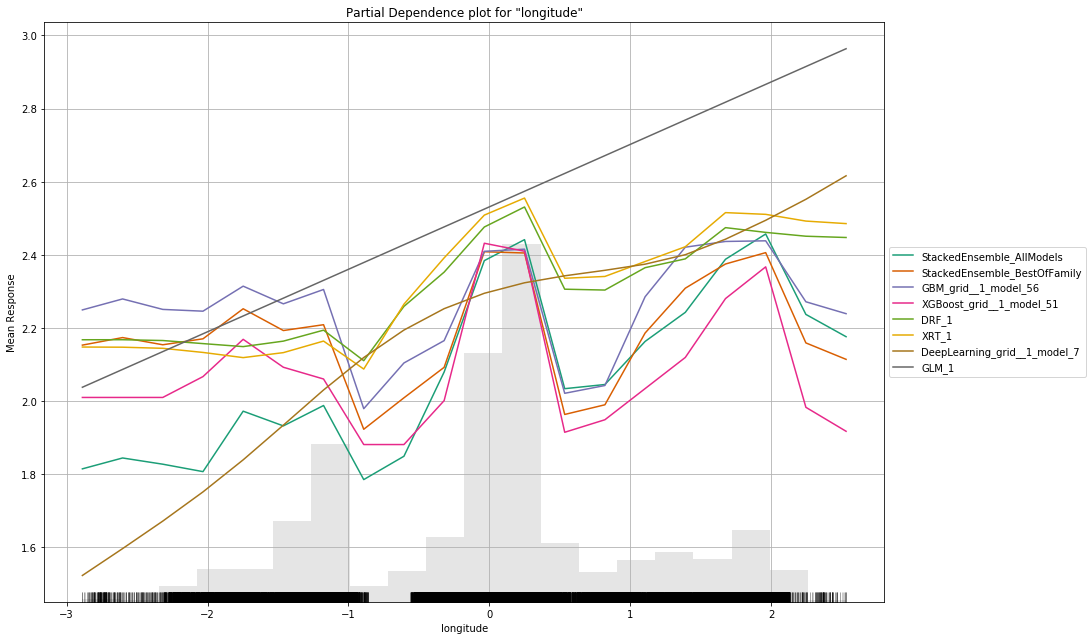

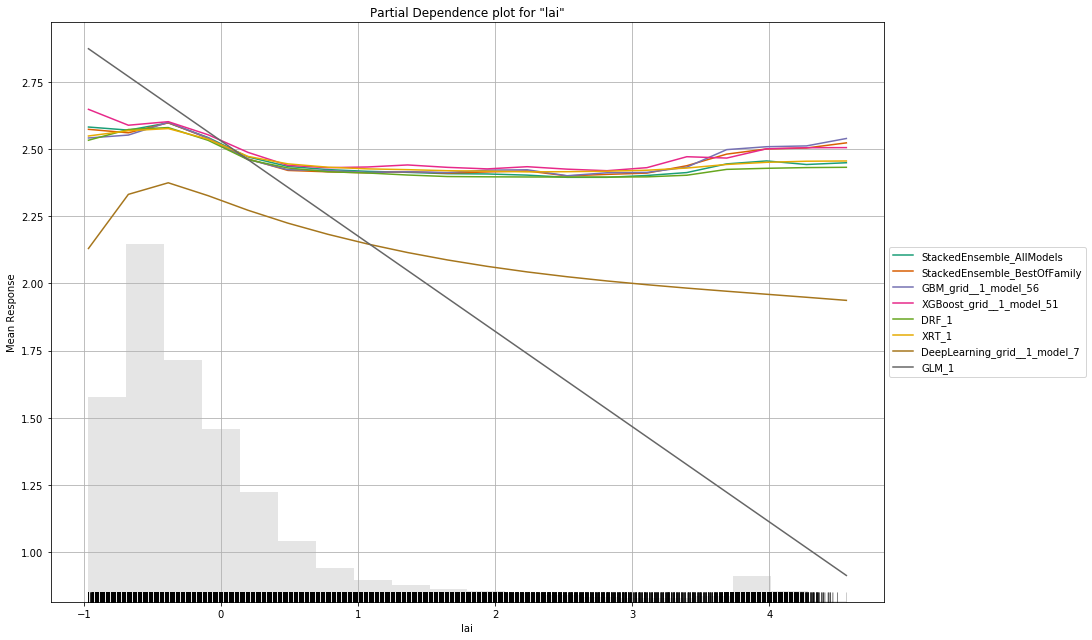

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

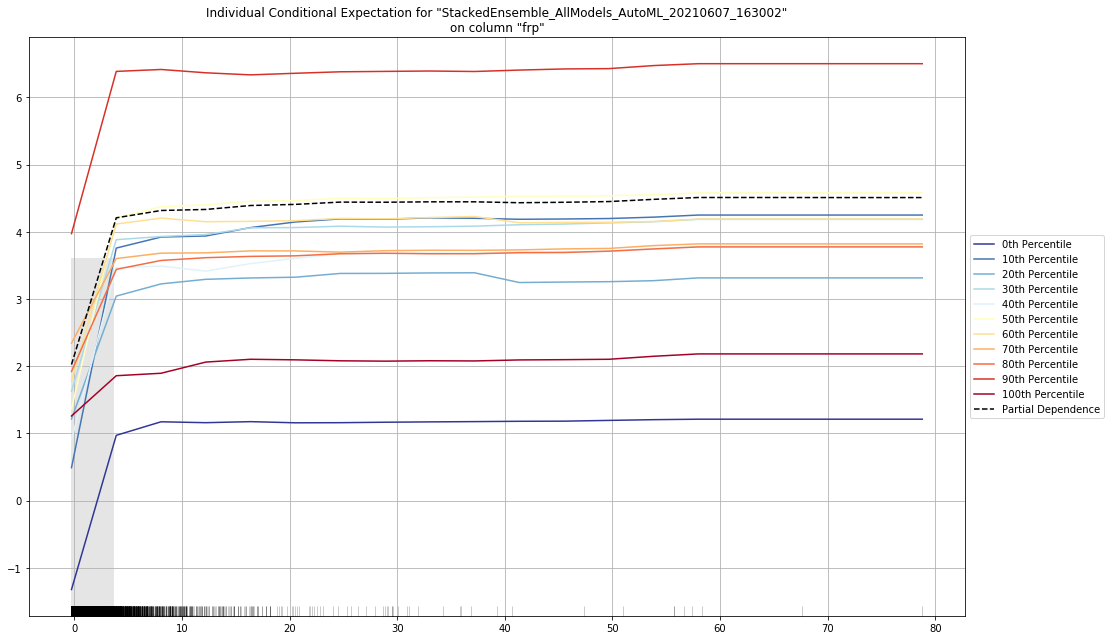

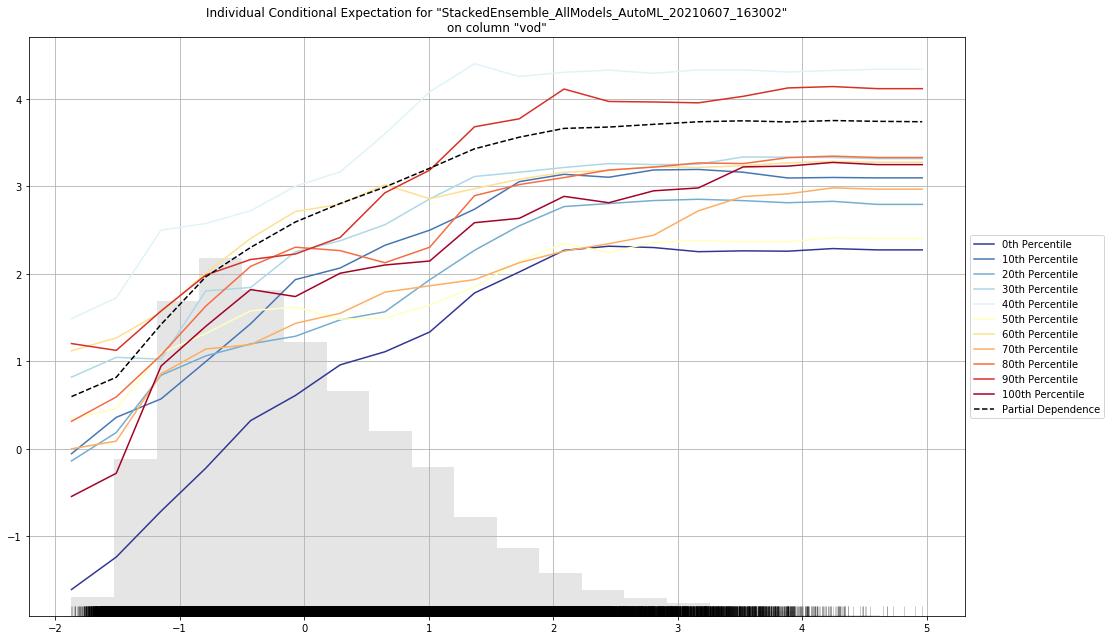

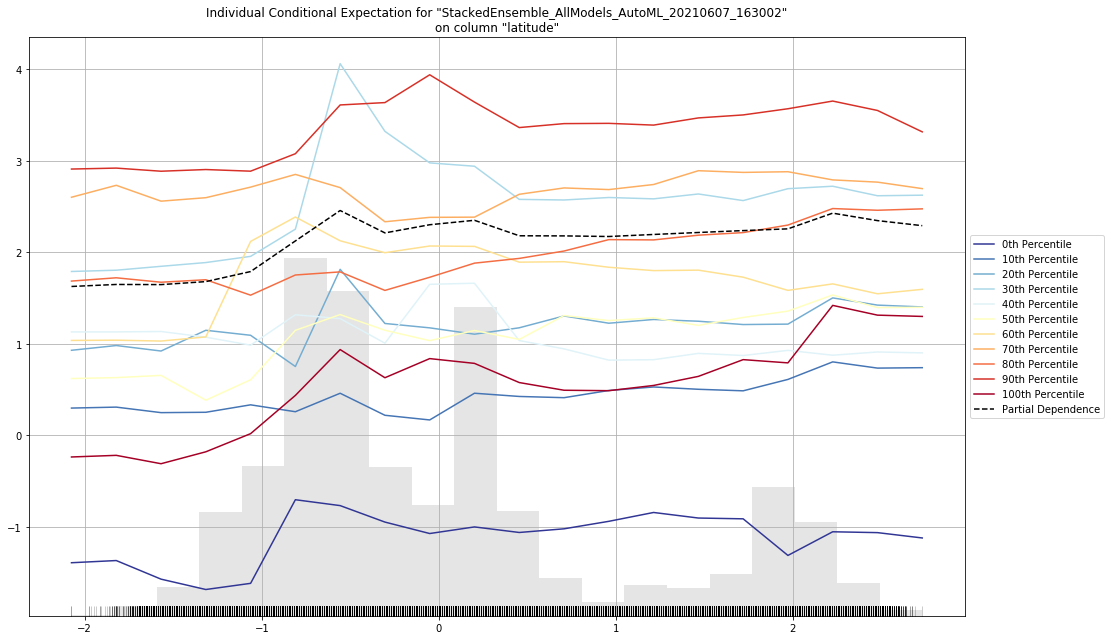

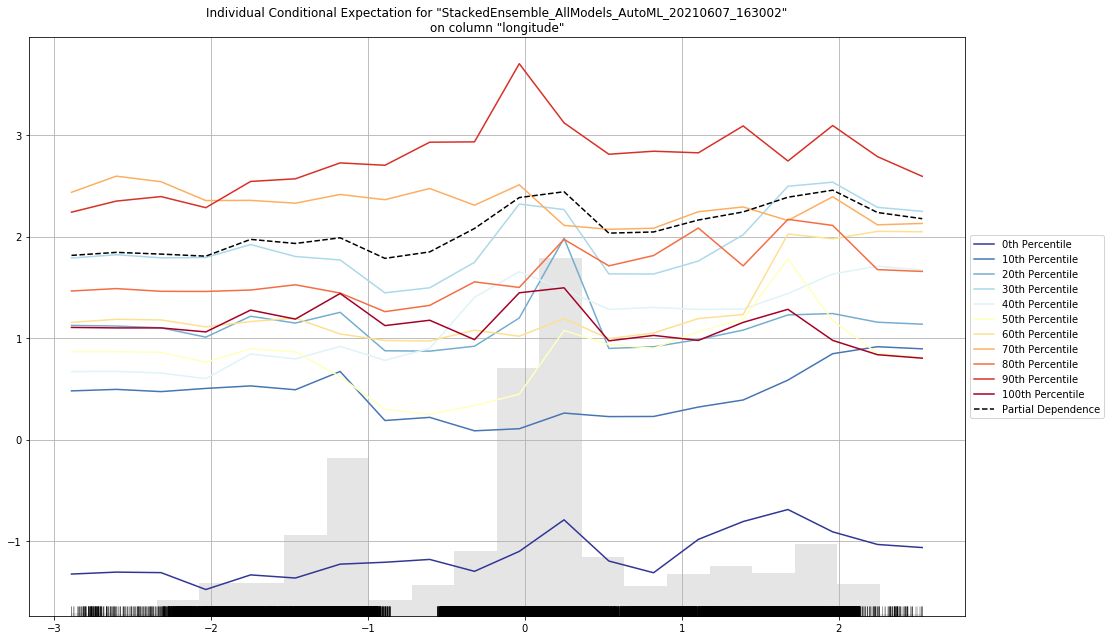

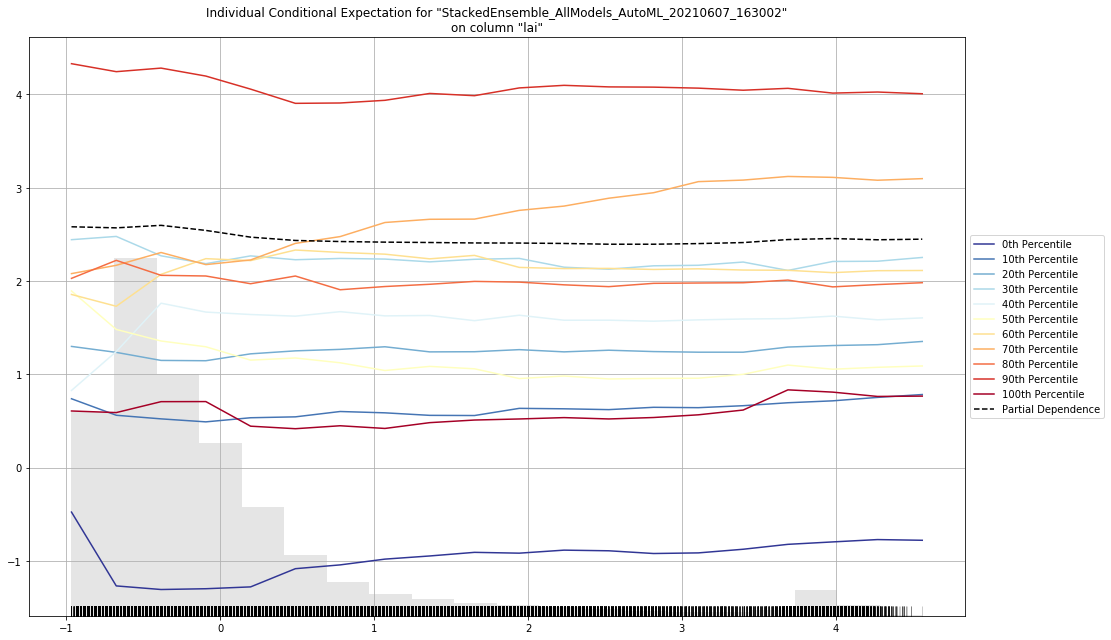

In [11]:
# Explain an AutoML object
exa = aml.explain(test_data)

## Time series

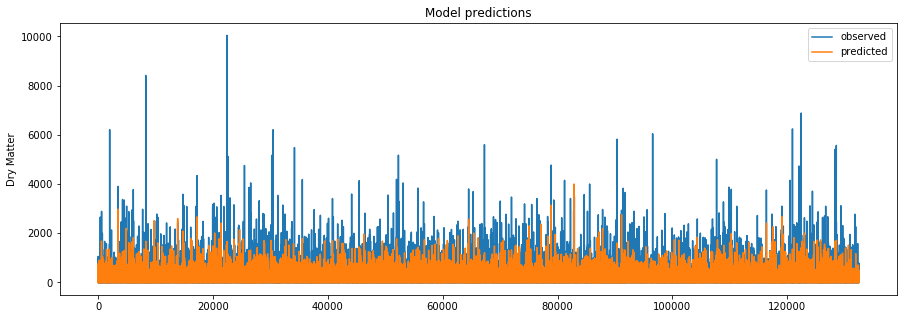

In [15]:
# Plot predictions
plt.plot(obs)
plt.plot(pre)
plt.title('Model predictions')
plt.ylabel('Dry Matter')
plt.xlabel('')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

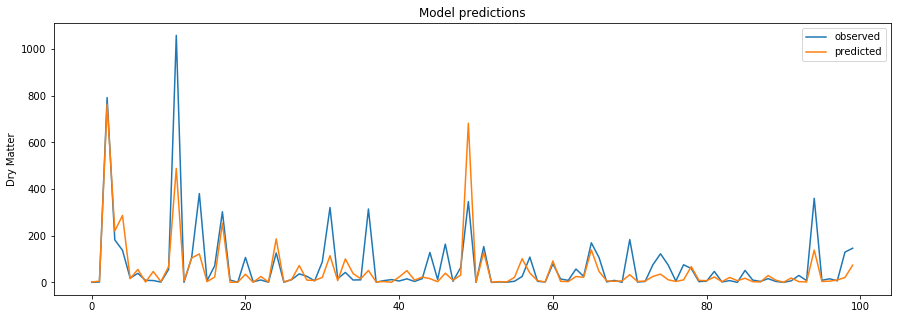

In [16]:
# Select a biome
idx = test['biome'] == 1

# Plot predictions
plt.plot(obs[0:100])
plt.plot(pre[0:100])
plt.title('Model predictions')
plt.ylabel('Dry Matter')
plt.xlabel('')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

# Map

In [17]:
# Add transformed back observations, prediction and residuals to the test data frame
test_raw['prediction'] = pre
test_raw['residual'] = test_raw['prediction'] - test_raw['dry_matter']
test_raw['residual_sign'] = np.where(test_raw['residual'] == 0, 'zero',
                                     np.where(test_raw['residual'] > 0, 'positive', 'negative'))
test_raw

,latitude,longitude,dry_matter,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,...,infsinx,fbupinx,fdsrte,frp,daysElapsed,timeYear,timeMonth,prediction,residual,residual_sign
0,-14.125,-43.625,0.637926,4.0,1.0,5.0,0.001862,0.280403,0.899991,0.124609,...,0.630047,18.051723,1.645894,0.003937,1765,2014,11,2.064887,1.426961,positive
1,-15.875,18.375,2.027269,3.0,1.0,9.0,0.003352,0.235407,0.588883,0.878517,...,1.969392,63.219906,4.600344,0.000000,1277,2013,7,5.639390,3.612121,positive
2,5.375,28.875,791.847741,4.0,1.0,8.0,0.003062,0.531788,0.922213,-1.109352,...,0.449267,5.097896,0.836676,0.417923,1795,2014,12,763.954092,-27.893649,negative
3,-18.875,33.375,182.594167,3.0,1.0,9.0,0.014721,0.364745,0.311108,-0.205468,...,-0.335389,-28.620920,-1.740059,0.055191,243,2010,9,220.696843,38.102675,positive
4,7.625,-2.625,137.816458,4.0,1.0,8.0,0.003877,0.616257,0.999990,1.105078,...,3.576173,-5.271719,6.633287,0.019714,1096,2013,1,287.054485,149.238027,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132504,-13.875,22.125,11.398151,3.0,1.0,9.0,0.000576,0.312607,0.288886,-0.283592,...,0.838159,22.556030,1.998066,0.003937,608,2011,9,12.224819,0.826668,positive
132505,4.375,17.625,781.737678,4.0,1.0,8.0,0.008820,0.589686,0.877769,1.925390,...,0.149598,-9.457446,-0.957595,0.023651,334,2010,12,469.220669,-312.517009,negative
132506,-11.875,21.375,202.957233,3.0,1.0,9.0,0.000306,0.290317,0.266664,0.187110,...,0.089159,-16.323260,0.064647,0.051254,2007,2015,7,169.885501,-33.071732,negative
132507,18.625,-102.625,81.223411,4.0,1.0,3.0,0.043172,0.505241,0.399996,0.075781,...,3.053280,50.202015,7.200427,0.011826,1216,2013,5,36.788492,-44.434919,negative


In [18]:
# Group results averaging over all days for each point (lat,lon)
grouped_test = test_raw.groupby(['latitude', 'longitude'],
                            as_index=False).agg({'dry_matter': ['mean'],
                                                 'prediction': ['mean'],
                                                 'residual': ['mean']})
grouped_test.columns = ['latitude', 'longitude', 'dry_matter', 'prediction', 'residual']
grouped_test.describe()

,latitude,longitude,dry_matter,prediction,residual
count,44997.000000,44997.000000,44997.000000,44997.000000,44997.000000
mean,12.484752,20.060212,71.796812,43.594660,-28.202153
std,29.955204,74.327638,199.257848,98.934522,143.103344
min,-48.375000,-162.625000,0.000054,0.051472,-7701.320189
25%,-13.375000,-48.375000,3.510049,3.642212,-16.691602
50%,7.375000,26.625000,14.104767,11.829675,-1.209786
75%,46.125000,77.125000,56.598447,39.972425,2.255198
max,72.125000,178.125000,8409.015059,3139.159278,1285.507564


In [19]:
crs = {'init': 'epsg:4326'}
# Get coastline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(grouped_test,
                       geometry=gpd.points_from_xy(x = grouped_test.longitude,
                                                   y = grouped_test.latitude))

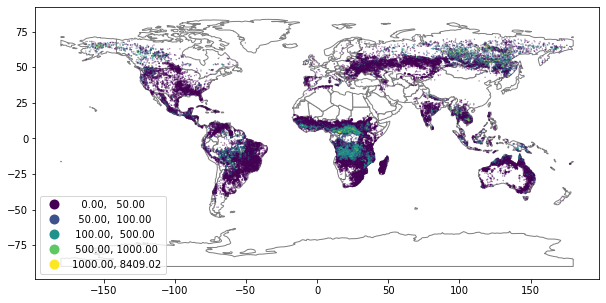

In [20]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='gray')

gdf.plot(column='dry_matter', #cmap='RdBu', 
         scheme="User_Defined",
         classification_kwds=dict(bins=[50, 100, 500, 1000]),
         markersize = 0.05,
         legend=True, 
         ax=ax)

plt.show()

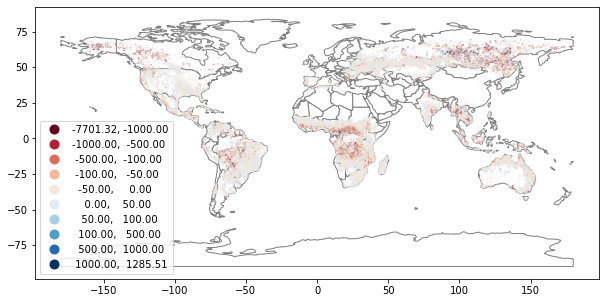

In [21]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='gray')

gdf.plot(column='residual', cmap='RdBu', 
         scheme="User_Defined",
         classification_kwds=dict(bins=[-1000, -500, -100, -50, 
                                        0, 
                                        50, 100, 500, 1000]),
         markersize = 0.05,
         legend=True, 
         ax=ax)

plt.show()

## Group statistics

In [22]:
# Group results averaging over all days for each point (lat,lon)
grouped_test2 = test_raw.groupby(['biome', 'residual_sign'], as_index=False).agg({'dry_matter': ['mean'],
                                                                                  'residual': ['mean']})
grouped_test2.columns = ['biome', 'residual_sign', 'dry_matter', 'residual']
grouped_test2['biome_names'] = np.repeat(['SA', 'SAOS', 'AG', 'AGOS', 'TF', 'PEAT', 'EF', 'EFOS'], 2)
grouped_test2

,biome,residual_sign,dry_matter,residual,biome_names
0,1.0,negative,123.023856,-61.630003,SA
1,1.0,positive,30.876956,18.391105,SA
2,2.0,negative,82.059481,-54.852678,SAOS
3,2.0,positive,11.243260,11.706599,SAOS
4,3.0,negative,19.417161,-13.452322,AG
5,3.0,positive,2.370359,2.617083,AG
6,4.0,negative,26.982751,-18.750605,AGOS
7,4.0,positive,2.945825,3.572270,AGOS
8,5.0,negative,187.354151,-118.088479,TF
9,5.0,positive,27.311927,23.247063,TF


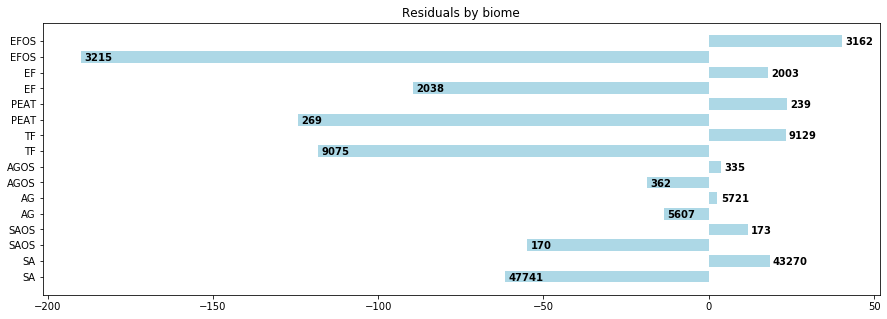

In [24]:
y = grouped_test2.residual
x = grouped_test2.biome_names
labels = test_raw.groupby(['biome', 'residual_sign'], as_index=False).size()
labels = labels['size']
ind = np.arange(len(x))

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.barh(ind, y, width, color="lightblue")
ax.set_yticks(ind)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(y):
    ax.text(v + 1, i - .25, str(labels[i]), color='black', fontweight='bold')
plt.title('Residuals by biome')
plt.xlabel('')
plt.ylabel('')      
plt.show()

In [25]:
# Group results averaging over all days for each point (lat,lon)
grouped_test3 = test_raw.groupby(['GFEDregions', 'residual_sign'], as_index=False).agg({'dry_matter': ['mean'],
                                                                  'residual': ['mean']})
grouped_test3.columns = ['GFEDregions', 'residual_sign', 'dry_matter', 'residual']
grouped_test3['GFEDnames'] = np.repeat(['BONA', 'TENA', 'CEAM', 'NHSA', 'SHSA', 'EURO', 'MIDE',
                              'NHAF', 'SHAF', 'BOAS', 'CEAS', 'SEAS', 'EQAS', 'AUST'], 2)
grouped_test3

,GFEDregions,residual_sign,dry_matter,residual,GFEDnames
0,1.0,negative,212.749244,-141.140860,BONA
1,1.0,positive,31.856082,30.385274,BONA
2,10.0,negative,191.209817,-123.149332,TENA
3,10.0,positive,25.142089,25.820831,TENA
4,11.0,negative,31.021731,-23.172906,CEAM
5,11.0,positive,3.311345,3.570343,CEAM
6,12.0,negative,196.146812,-139.027464,NHSA
7,12.0,positive,19.727559,20.101270,NHSA
8,13.0,negative,143.500935,-101.388431,SHSA
9,13.0,positive,19.134057,21.230677,SHSA


In [ ]:
# Define plot size
plt.rcParams["figure.figsize"] = (15,10)

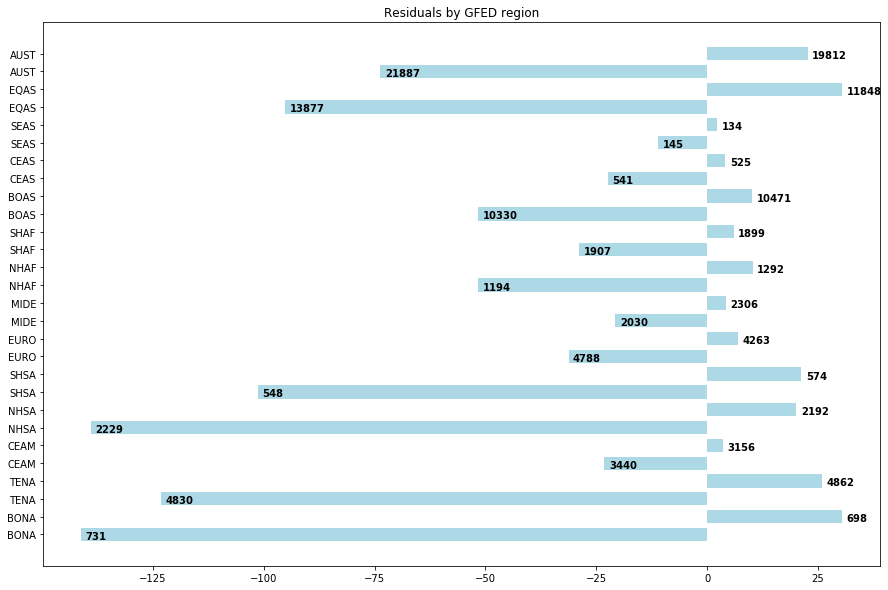

In [28]:
y = grouped_test3.residual
x = grouped_test3.GFEDnames
labels = test_raw.groupby(['GFEDregions', 'residual_sign'], as_index=False).size()
labels = labels['size']
ind = np.arange(len(x))

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.barh(ind, y, width, color="lightblue")
ax.set_yticks(ind)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(y):
    ax.text(v + 1, i - .25, str(labels[i]), color='black', fontweight='bold')
plt.title('Residuals by GFED region')
plt.xlabel('')
plt.ylabel('')      
plt.show()